# Denoising Autoencoders And Where To Find Them

homework done for coursera intro to dl course

In [1]:
import sys
sys.path.append("..")
import grading

In [3]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import keras_utils
import numpy as np

In [4]:
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [6]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [7]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


2991

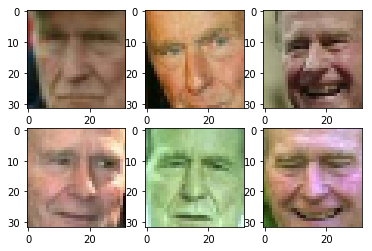

In [8]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

### PCA autoencoder

In [9]:
def build_pca_autoencoder(img_shape, code_size):

    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  
    encoder.add(L.Dense(code_size))           

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  
    decoder.add(L.Reshape(img_shape))         
    
    return encoder,decoder

In [11]:
s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)

Epoch 1/15

Epoch 2/15

Epoch 3/15

Epoch 4/15

Epoch 5/15

Epoch 6/15

Epoch 7/15

Epoch 8/15

Epoch 9/15

Epoch 10/15

Epoch 11/15

Epoch 12/15

Epoch 13/15

Epoch 14/15

Epoch 15/15



In [19]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.00662189818841


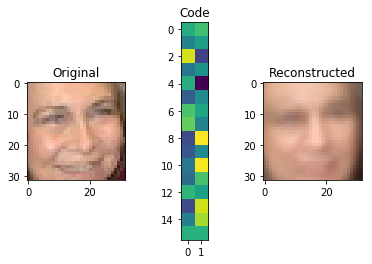

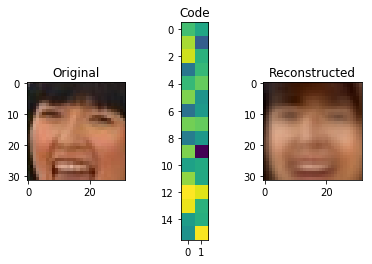

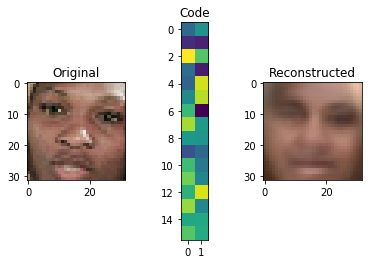

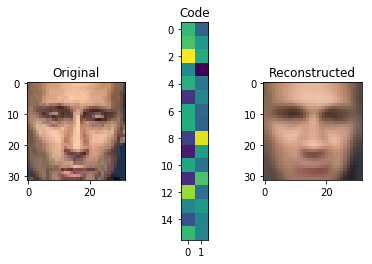

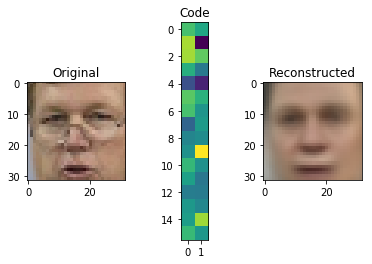

In [14]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

Convolutional autoencoder

In [10]:
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    with tf.Session() as session:
        result = session.run(conv)
        print("input:")
        print(x[0, :, :, 0])
        print("filter:")
        print(f[:, :, 0, 0])
        print("output:")
        print(result[0, :, :, 0])
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[ 1.  2.]
 [ 3.  4.]]
filter:
[[ 1.  1.]
 [ 1.  1.]]
output:
[[ 1.  1.  2.  2.]
 [ 1.  1.  2.  2.]
 [ 3.  3.  4.  4.]
 [ 3.  3.  4.  4.]]
Transpose convolution test for img_size=2, filter_size=3:
input:
[[ 1.  2.]
 [ 3.  4.]]
filter:
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]
output:
[[  1.   1.   3.   2.]
 [  1.   1.   3.   2.]
 [  4.   4.  10.   6.]
 [  3.   3.   7.   4.]]
Transpose convolution test for img_size=4, filter_size=2:
input:
[[  1.   2.   3.   4.]
 [  5.   6.   7.   8.]
 [  9.  10.  11.  12.]
 [ 13.  14.  15.  16.]]
filter:
[[ 1.  1.]
 [ 1.  1.]]
output:
[[  1.   1.   2.   2.   3.   3.   4.   4.]
 [  1.   1.   2.   2.   3.   3.   4.   4.]
 [  5.   5.   6.   6.   7.   7.   8.   8.]
 [  5.   5.   6.   6.   7.   7.   8.   8.]
 [  9.   9.  10.  10.  11.  11.  12.  12.]
 [  9.   9.  10.  10.  11.  11.  12.  12.]
 [ 13.  13.  14.  14.  15.  15.  16.  16.]
 [ 13.  13.  14.  14.  15.  15.  16.  16.]]
Transpose c

In [11]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(L.Conv2D(filters=32, kernel_size=3, padding='same'))
    encoder.add(L.ELU())
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(filters=64, kernel_size=3, padding='same'))
    encoder.add(L.ELU())
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(filters=128, kernel_size=3, padding='same'))
    encoder.add(L.ELU())
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Conv2D(filters=256, kernel_size=3, padding='same'))
    encoder.add(L.ELU())
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))
    encoder.add(L.ELU())

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense(np.prod(1024)))
    decoder.add(L.Reshape((2,2,256)))
    
    
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    
    return encoder, decoder

In [14]:
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
elu_1 (ELU)                  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
elu_2 (ELU)                  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [152]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [154]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [155]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.ModelSaveCallback(model_filename),
                           keras_utils.TqdmProgressCallback()],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)

Epoch 1/25
Model saved in autoencoder.000.hdf5

Epoch 2/25
Model saved in autoencoder.001.hdf5

Epoch 3/25
Model saved in autoencoder.002.hdf5

Epoch 4/25
Model saved in autoencoder.003.hdf5

Epoch 5/25
Model saved in autoencoder.004.hdf5

Epoch 6/25
Model saved in autoencoder.005.hdf5

Epoch 7/25
Model saved in autoencoder.006.hdf5

Epoch 8/25
Model saved in autoencoder.007.hdf5

Epoch 9/25
Model saved in autoencoder.008.hdf5

Epoch 10/25
Model saved in autoencoder.009.hdf5

Epoch 11/25
Model saved in autoencoder.010.hdf5

Epoch 12/25
Model saved in autoencoder.011.hdf5

Epoch 13/25
Model saved in autoencoder.012.hdf5

Epoch 14/25
Model saved in autoencoder.013.hdf5

Epoch 15/25
Model saved in autoencoder.014.hdf5

Epoch 16/25
Model saved in autoencoder.015.hdf5

Epoch 17/25
Model saved in autoencoder.016.hdf5

Epoch 18/25
Model saved in autoencoder.017.hdf5

Epoch 19/25
Model saved in autoencoder.018.hdf5

Epoch 20/25
Model saved in autoencoder.019.hdf5

Epoch 21/25
Model saved in au

Convolutional autoencoder MSE: 0.00563597520087


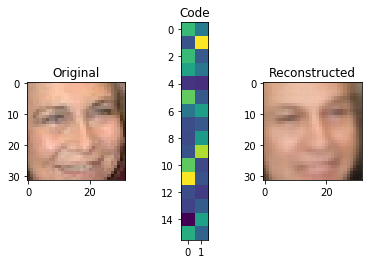

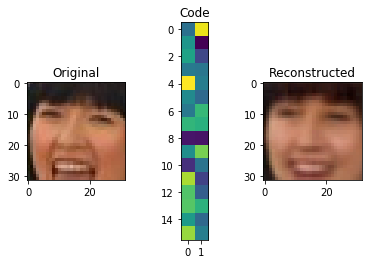

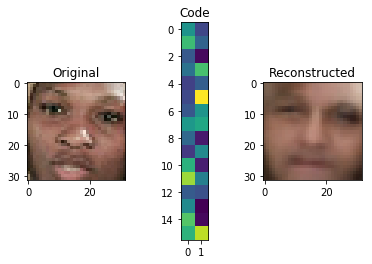

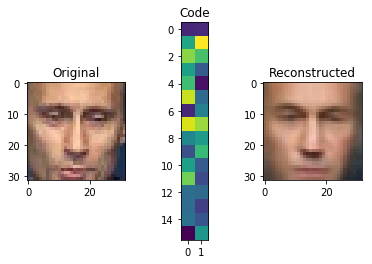

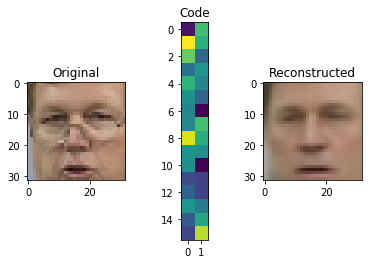

In [156]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [157]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [158]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.00563597520087
0.00563597520087


### denoising autoencoder

In [15]:
def apply_gaussian_noise(X,sigma=0.1):
    noise = np.random.normal(scale=sigma, size=X.shape)
    return X + noise

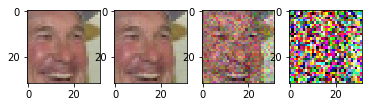

In [163]:
# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [17]:
s = reset_tf_session()

# we use bigger code size here for better quality
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    callbacks=[keras_utils.TqdmProgressCallback()],
                    verbose=0)

Epoch 1/25, Generating corrupted samples...
Epoch 1/1

Epoch 2/25, Generating corrupted samples...
Epoch 1/1

Epoch 3/25, Generating corrupted samples...
Epoch 1/1

Epoch 4/25, Generating corrupted samples...
Epoch 1/1

Epoch 5/25, Generating corrupted samples...
Epoch 1/1

Epoch 6/25, Generating corrupted samples...
Epoch 1/1

Epoch 7/25, Generating corrupted samples...
Epoch 1/1

Epoch 8/25, Generating corrupted samples...
Epoch 1/1

Epoch 9/25, Generating corrupted samples...
Epoch 1/1

Epoch 10/25, Generating corrupted samples...
Epoch 1/1

Epoch 11/25, Generating corrupted samples...
Epoch 1/1

Epoch 12/25, Generating corrupted samples...
Epoch 1/1

Epoch 13/25, Generating corrupted samples...
Epoch 1/1

Epoch 14/25, Generating corrupted samples...
Epoch 1/1

Epoch 15/25, Generating corrupted samples...
Epoch 1/1

Epoch 16/25, Generating corrupted samples...
Epoch 1/1

Epoch 17/25, Generating corrupted samples...
Epoch 1/1

Epoch 18/25, Generating corrupted samples...
Epoch 1/1

E

Denoising MSE: 0.00277928092204


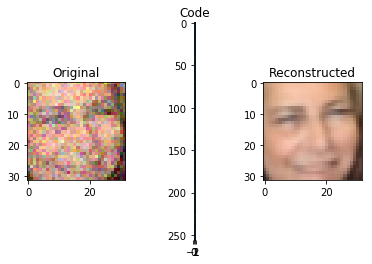

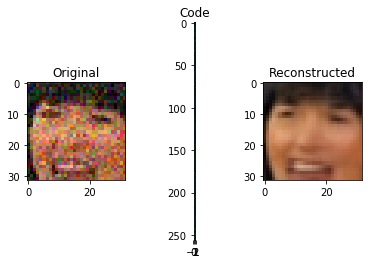

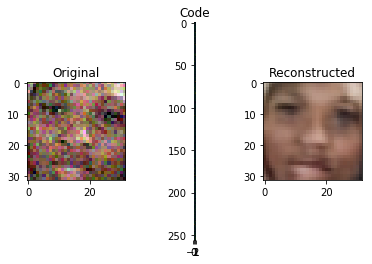

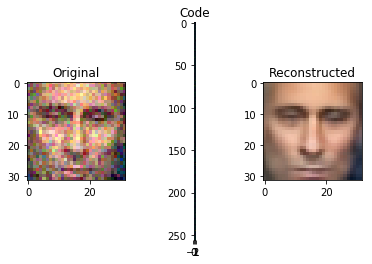

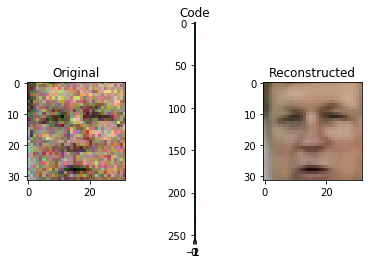

In [20]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

### Image retrieval with autoencoders

In [21]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [23]:
X_train[:10].shape

(10, 32, 32, 3)

In [25]:
encoder.predict(X_train[:10]).shape

(10, 32)

In [ ]:
encoder.predict(img[None])[0]

In [26]:
images = X_train
codes = encoder.predict(X_train)
assert len(codes) == len(images)

In [27]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [28]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [29]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

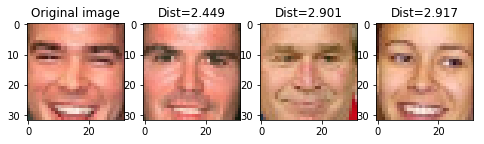

In [30]:
# smiles
show_similar(X_test[247])

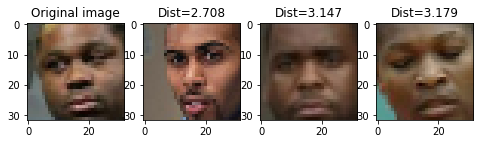

In [31]:
# ethnicity
show_similar(X_test[56])

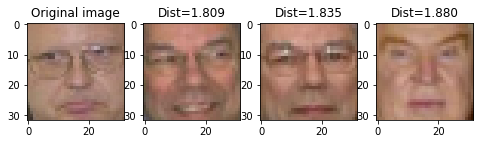

In [32]:
# glasses
show_similar(X_test[63])

### image morphing


In [33]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

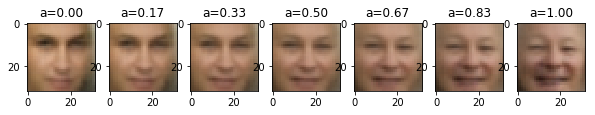

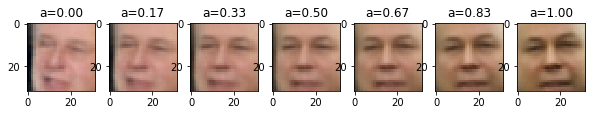

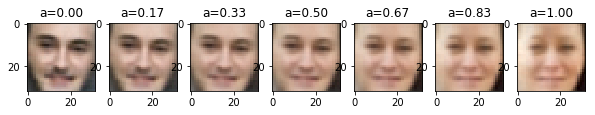

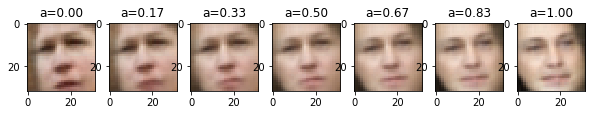

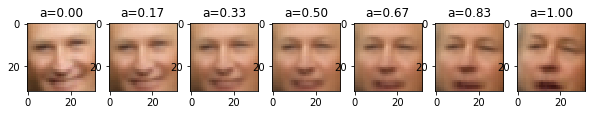

In [34]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()